In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import cmath
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from statsmodels.tsa.api import VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from multiproc import compute_VAR
from multiproc_VAR_p_grid_search import compute_VAR_p, predict_VAR_p
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [3]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

# Get Signal

In [7]:
area = 'vlPFC'
if area == 'all':
    area_indices = np.arange(len(electrode_info['area']))
else:
    area_indices = np.where(electrode_info['area'] == area)[0]

big_window_start = 30*60 # s
big_window_length = 100 # s
big_window_start_ind = int(big_window_start/dt)
big_window_end_ind = big_window_start_ind + int(big_window_length/dt)
signal_in = lfp[big_window_start_ind:big_window_end_ind, area_indices]

# VAR on Delay Embedding

In [8]:
delays = 4
window = 5.5 # s

windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.1, 0.5)]
# windows = np.hstack([np.arange(0.05, 0.101, 0.01), [0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]])
# windows = [0.25, 0.5, 0.75, 1, 2, 3, 4, 5]
max_lag = 15
lags = np.arange(1, max_lag + 1)
T_pred = 25
num_window_samples = 10

In [29]:
d = 10
indices = np.random.choice(np.arange(signal_in.shape[1]), size=(d, ), replace=False)

In [30]:
data = signal_in[:, indices]

In [31]:
grid_search_df = []
grid_search_df_de = []
iterator = tqdm(total = len(windows)*len(lags))
for window in windows:
    stride = window
    
    min_ind = int(0/stride)
    max_ind = int((data.shape[0]*dt - window - T_pred*dt)/stride)
    possible_inds = np.arange(min_ind, max_ind + 1)
    window_inds = np.random.choice(possible_inds, size=(np.min([num_window_samples, len(possible_inds)])), replace=False)
#     num_windows = int(np.floor((data.shape[0]-window)/stride)+1)
    for p in lags:
#         for i in range(num_windows):
        for i in window_inds:
            start_ind = i*int(stride/dt)
            start_time = i*stride
            end_ind = i*int(stride/dt) + int(window/dt)
            end_time = i*stride + window
            if end_ind + T_pred <= data.shape[0]:
                
                # =========================
                # ORDINARY VAR(p)
                # =========================
                window_data = data[start_ind:end_ind]
                results = compute_VAR_p(window_data, p)
                test_data = data[end_ind - p:end_ind + T_pred]

                train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
                train_mse = ((train_prediction - train_true_vals)**2).mean()
                test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
#                 print(test_prediction.shape)
                test_mse = ((test_prediction - test_true_vals)**2).mean()
                persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

                # ADD TO DICTIONARY
                results['train_mse'] = train_mse
                results['test_mse'] = test_mse
                results['persistence_baseline'] = persistence_baseline

                # ADD TIMESTAMPS
                results['start_ind'] = start_ind
                results['end_ind'] = end_ind
                results['start_time'] = start_time
                results['end_time'] = end_time

                # ADD PARAMETERS
                results['window'] = window
                results['stride'] = stride
                results['p'] = p
                results['T_pred'] = T_pred
                
                grid_search_df.append(results)
                
                # =========================
                # VAR on Delay Embedding
                # =========================
                
                window_data_de = np.zeros((window_data.shape[0] - p, window_data.shape[1]*p))
                for delay in range(p):
                    window_data_de[:, delay*window_data.shape[1]:(delay + 1)*window_data.shape[1]] = window_data[delay:(-p + delay)]
                
                results = compute_VAR_p(window_data_de, 1)
                test_data = np.zeros((T_pred, window_data.shape[1]*p))
                for delay in range(p):
                    test_data[:, delay*window_data.shape[1]:(delay + 1)*window_data.shape[1]] = data[end_ind + delay:end_ind + delay + T_pred]

                train_prediction, train_true_vals = predict_VAR_p(window_data_de, results['coefs'], results['intercept'])
                train_mse = ((train_prediction - train_true_vals)**2).mean()
                test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
#                 print(test_prediction.shape)
                test_mse = ((test_prediction - test_true_vals)**2).mean()
                
                test_data_naive = np.zeros((T_pred, window_data.shape[1]*p))
                for delay in range(p):
                    test_data_naive[:, delay*window_data.shape[1]:(delay + 1)*window_data.shape[1]] = data[end_ind + delay-1:end_ind + delay + T_pred -1]
                persistence_baseline = ((test_data - test_data_naive)**2).mean()

                # ADD TO DICTIONARY
                results['train_mse'] = train_mse
                results['test_mse'] = test_mse
                results['persistence_baseline'] = persistence_baseline

                # ADD TIMESTAMPS
                results['start_ind'] = start_ind
                results['end_ind'] = end_ind
                results['start_time'] = start_time
                results['end_time'] = end_time

                # ADD PARAMETERS
                results['window'] = window
                results['stride'] = stride
                results['p'] = p
                results['T_pred'] = T_pred
                
                grid_search_df_de.append(results)
                
        iterator.update()
iterator.close()
grid_search_df = pd.DataFrame(grid_search_df)
grid_search_df_de = pd.DataFrame(grid_search_df_de)

  0%|          | 0/300 [00:00<?, ?it/s]

In [42]:
test_mse_mat = np.zeros((len(windows), len(lags)))
for i, window in enumerate(windows):
    for j, p in enumerate(lags):
        test_mse_mat[i, j] = grid_search_df[np.logical_and(grid_search_df.window == window, grid_search_df.p == p)].test_mse.mean()

test_mse_mat_de = np.zeros((len(windows), len(lags)))
for i, window in enumerate(windows):
    for j, p in enumerate(lags):
        test_mse_mat_de[i, j] = grid_search_df_de[np.logical_and(grid_search_df_de.window == window, grid_search_df_de.p == p)].test_mse.mean()

In [43]:
def pick_2d_optimum(mat, thresh=0.95):
    true_min = mat.min()
    i_vals, j_vals = np.where(mat*thresh - true_min <= 0)
    selected_i = np.min(i_vals)
    selected_j = np.min(j_vals[i_vals == selected_i])
    selected_i, selected_j

    return selected_i, selected_j
thresh = 1
w_ind, p_ind = pick_2d_optimum(test_mse_mat, thresh)
w_ind_de, p_ind_de = pick_2d_optimum(test_mse_mat_de, thresh)

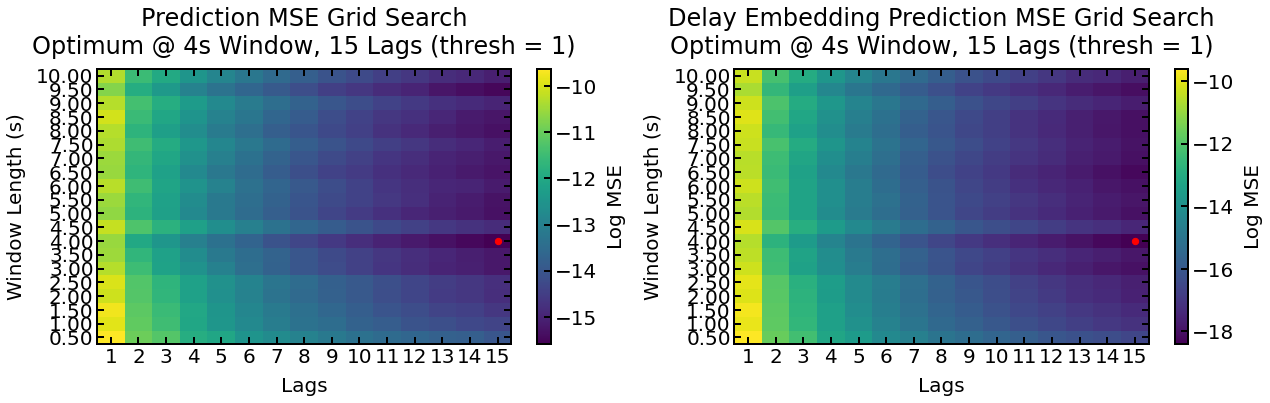

In [44]:
log_test_mse_mat = np.log(test_mse_mat)
log_test_mse_mat_de = np.log(test_mse_mat_de)
plt.style.use('../../sci_style.py')
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
# norm = colors.TwoSlopeNorm(vmin=test_mse_mat.min(), vcenter=test_mse_mat.mean(), vmax=test_mse_mat.max())
# plt.pcolormesh(test_mse_mat, norm=norm)
plt.pcolormesh(log_test_mse_mat)
plt.xticks(np.arange(0, max_lag) + 0.5, [lags[i] for i in np.arange(0, max_lag)])
plt.yticks(np.arange(0, len(windows)) + 0.5, [f"{windows[i]:.2f}" for i in np.arange(0, len(windows))])
plt.xlabel('Lags')
plt.ylabel('Window Length (s)')
cbar = plt.colorbar(label='Log MSE')
# cbar_ticks = [norm.vmin + t*(norm.vcenter-norm.vmin) for t in np.arange(0, 1.1, 0.2)]
# cbar_ticks += [norm.vcenter + t*(norm.vmax-norm.vcenter) for t in np.arange(0, 1.1, 0.2)]
# cbar.set_ticks(cbar_ticks)
plt.scatter([p_ind + 0.5], [w_ind + 0.5], color='red', s=40, label='min')
plt.tight_layout()
plt.title(f"Prediction MSE Grid Search\nOptimum @ {windows[w_ind]}s Window, {lags[p_ind]} Lags (thresh = {thresh})")
plt.subplot(1, 2, 2)
# norm = colors.TwoSlopeNorm(vmin=test_mse_mat.min(), vcenter=test_mse_mat.mean(), vmax=test_mse_mat.max())
# plt.pcolormesh(test_mse_mat, norm=norm)
plt.pcolormesh(log_test_mse_mat_de)
plt.xticks(np.arange(0, max_lag) + 0.5, [lags[i] for i in np.arange(0, max_lag)])
plt.yticks(np.arange(0, len(windows)) + 0.5, [f"{windows[i]:.2f}" for i in np.arange(0, len(windows))])
plt.xlabel('Lags')
plt.ylabel('Window Length (s)')
cbar = plt.colorbar(label='Log MSE')
# cbar_ticks = [norm.vmin + t*(norm.vcenter-norm.vmin) for t in np.arange(0, 1.1, 0.2)]
# cbar_ticks += [norm.vcenter + t*(norm.vmax-norm.vcenter) for t in np.arange(0, 1.1, 0.2)]
# cbar.set_ticks(cbar_ticks)
plt.scatter([p_ind_de + 0.5], [w_ind_de + 0.5], color='red', s=40, label='min')
plt.tight_layout()
plt.title(f"Delay Embedding Prediction MSE Grid Search\nOptimum @ {windows[w_ind_de]}s Window, {lags[p_ind_de]} Lags (thresh = {thresh})")
plt.show()

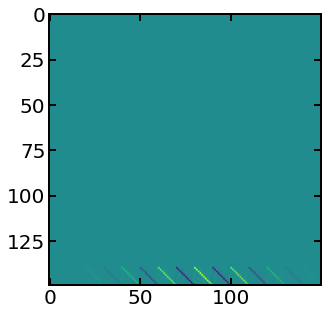

In [53]:
plt.imshow(grid_search_df_de[np.logical_and(grid_search_df_de.window == windows[w_ind_de], grid_search_df_de.p == lags[p_ind_de])].coefs.iloc[0][0])
plt.show()

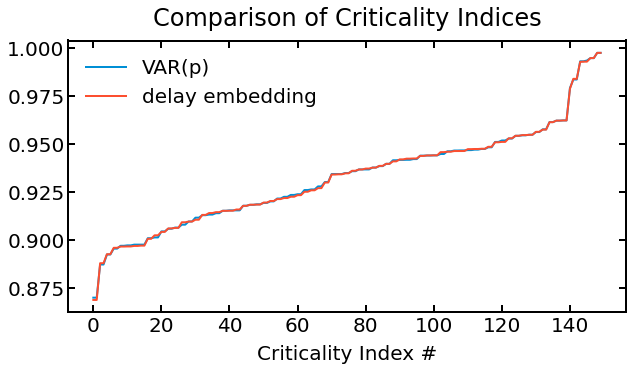

In [59]:
plt.plot(np.sort(grid_search_df[np.logical_and(grid_search_df.window == windows[w_ind], grid_search_df.p == lags[p_ind])].criticality_inds.iloc[0]), label='VAR(p)')
plt.plot(np.sort(grid_search_df_de[np.logical_and(grid_search_df_de.window == windows[w_ind_de], grid_search_df_de.p == lags[p_ind_de])].criticality_inds.iloc[0]), label='delay embedding')
plt.xlabel('Criticality Index #')
plt.title('Comparison of Criticality Indices')
plt.legend()
plt.show()